Problem: Predicting Telecom Customer Churn

#Introduction to the Business Scenario
You are a data scientist at a telecom company facing a growing challenge with customer churn. 
Over the past year, the company has observed a significant number of customers switching to competitors, leading to reduced revenue and an increase in customer acquisition costs. 
Management is keen to identify at-risk customers early and implement targeted retention strategies to minimize churn.

As part of the solution, you have been tasked with leveraging machine learning to predict customer churn. By accurately identifying customers who are likely to leave, the company can take proactive steps, such as offering incentives, discounts, or improved services, to retain these customers.

#About This Dataset
The dataset represents telecom customer records and includes demographic, account, and service information. It is designed to help predict whether a customer will churn or not. The dataset includes 7,043 unique customer entries with 21 attributes.

Features
Customer Demographics:
gender: Gender of the customer (Male/Female).
SeniorCitizen: Indicates whether the customer is a senior citizen (1 for Yes, 0 for No).
Partner: Indicates if the customer has a partner (Yes/No).
Dependents: Indicates if the customer has dependents (Yes/No).
Account Information:
tenure: Number of months the customer has been with the company.
MonthlyCharges: Monthly charges incurred by the customer.
TotalCharges: Total charges incurred by the customer.
Services Availed:
PhoneService: Indicates if the customer has a phone service (Yes/No).
MultipleLines: Indicates if the customer has multiple lines (Yes, No, No phone service).
InternetService: Type of internet service (DSL, Fiber optic, No).
OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport: Whether the customer has availed of these specific internet services (Yes, No, No internet service).
StreamingTV, StreamingMovies: Indicates if the customer uses streaming services (Yes, No, No internet service).
Contract and Payment Information:
Contract: Type of contract (Month-to-month, One year, Two year).
PaperlessBilling: Indicates if the customer uses paperless billing (Yes/No).
PaymentMethod: Payment method used by the customer (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
Target Variable:
Churn: Indicates whether the customer has churned (Yes/No).
Dataset Overview
This dataset was made publicly available on Kaggle under the name "Telco Customer Churn" by Blastchar. It provides valuable insights for building a predictive model to address customer retention challenges in the telecom industry.

Rows: 7,043
Columns: 21
Target Variable: Churn (binary classification: Yes/No).

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents.



### Read through a business scenario and:

### 1. Determine if and why ML is an appropriate solution to deploy.
\# Write your answer here

### 2. Formulate the business problem, success metrics, and desired ML output.
\# Write your answer here

### 3. Identify the type of ML problem you’re dealing with.
\# Write your answer here

### 4. Analyze the appropriateness of the data you’re working with.
\# Write your answer here


### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.


Replace **`<LabBucketName>`** with the resource name that was provided with your lab account.

In [1]:
import json
import boto3
import sagemaker
import pandas as pd
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initialize SageMaker session
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = '<LabBucketName>'  # specify your bucket name
prefix = 'telco-churn-example'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Step 2: Data preprocessing   
In this data preprocessing phase, you should take the opportunity to explore  your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?



# Load dataset
data = pd.read_csv('<CODE>')

Check the dataframe by printing the first 5 rows of the dataset.  

In [2]:
data = pd.read_csv('Telco-Customer-Churn.csv')
print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

**Question**: What can you find out about the column types and the null values? How many columns are numerical or categorical? 

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Check for missing values in the dataset. 
Convert the Total Charges column to numeric values replacing any missing values with the median.

In [4]:
# Convert 'TotalCharges' to numeric, and handle non-numeric values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

Drop the columns that do not provide any value to the solution.

In [5]:
# Drop 'customerID' column
data = data.drop(['customerID'], axis=1)

Convert binary variables like Churn (Yes/No) into numeric (0/1).Apply one-hot encoding for non-binary categorical variables like Contract (e.g., Monthly, Yearly).


In [6]:
# Encode binary categorical columns
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for column in binary_columns:
    data[column] = data[column].apply(lambda x: 1 if x in ['Yes', 'Female'] else 0)

# One-hot encode multi-category columns
categorical_columns = ['InternetService', 'Contract', 'PaymentMethod', 'MultipleLines', 
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

Scale numerical columns (tenure, MonthlyCharges, TotalCharges) using StandardScaler.

In [7]:
# Standardize numerical columns
scaler = StandardScaler()
data[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(data[['tenure', 'MonthlyCharges', 'TotalCharges']])

Observe the dataset.

In [8]:
print(data.head())

   gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       1              0        1           0 -1.277445             0   
1       0              0        0           0  0.066327             1   
2       0              0        0           0 -1.236724             1   
3       0              0        0           0  0.514251             0   
4       1              0        0           0 -1.236724             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1       -1.160323     -0.994242      0  ...   
1                 0       -0.259629     -0.173244      0  ...   
2                 1       -0.362660     -0.959674      1  ...   
3                 0       -0.746535     -0.194766      0  ...   
4                 1        0.197365     -0.940470      1  ...   

   OnlineBackup_No internet service  OnlineBackup_Yes  \
0                                 0                 1   
1                                 0                 0   

# Step 3: Model training and evaluation
Set up Sagemaker session and role. Specify your bucket and a prefix to store the output.
Lets start by instantiating the LinearLearner estimator with `predictor_type='binary_classifier'` parameter with one ml.m5.large instance.

In [9]:
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet
from sagemaker.inputs import TrainingInput
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sagemaker.amazon.linear_learner import LinearLearner 

# Set up SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()  # Ensure this role has the required permissions
bucket = 'sagemaker-us-west-2-935796931548'       # Replace with your S3 bucket name
prefix = 'telco-churn-linear-learner-3'         # S3 prefix for data storage

# Instantiate the LinearLearner estimator with an instance type of ml.m5large
linear = LinearLearner(
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    predictor_type='binary_classifier',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)


Sagemaker's Linear Learner requires input data to be numeric. 
Convert the numerical columns to float32
Split data into features and target. Further, split it in training, validation and test sets.
Convert all these data sets to NumPy arrays with float32

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assume `telco_data` is the dataset, and `Churn` is the target column.
telco_data = data
# Step 1: Convert all numerical columns to float32
telco_data = telco_data.astype({col: 'float32' for col in telco_data.select_dtypes(include=['float64', 'int64']).columns})

# Ensure the target variable ('Churn') is also float32
telco_data['Churn'] = telco_data['Churn'].astype('float32')

# Step 2: Split data into features (X) and target (y)
X = telco_data.drop(columns=['Churn'])  # Features
y = telco_data['Churn']  # Target

# Step 3: Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 4: Convert train, validation, and test sets to NumPy arrays with float32
train_features = X_train.to_numpy(dtype='float32')
train_labels = y_train.to_numpy(dtype='float32')
val_features = X_val.to_numpy(dtype='float32')
val_labels = y_val.to_numpy(dtype='float32')
test_features = X_test.to_numpy(dtype='float32')
test_labels = y_test.to_numpy(dtype='float32')

# Step 5: Verify the data types
print(f"Train features dtype: {train_features.dtype}, Train labels dtype: {train_labels.dtype}")
print(f"Validation features dtype: {val_features.dtype}, Validation labels dtype: {val_labels.dtype}")
print(f"Test features dtype: {test_features.dtype}, Test labels dtype: {test_labels.dtype}")

Train features dtype: float32, Train labels dtype: float32
Validation features dtype: float32, Validation labels dtype: float32
Test features dtype: float32, Test labels dtype: float32


Linear learner accepts training data in protobuf or CSV content types, and accepts inference requests in protobuf, CSV, or JSON content types. Training data has features and ground-truth labels, while the data in an inference request has only features. In a production pipeline, it is recommended to convert the data to the Amazon SageMaker protobuf format and store it in Amazon S3. However, to get up and running quickly, AWS provides the convenient method `record_set` for converting and uploading when the dataset is small enough to fit in local memory. It accepts NumPy arrays like the ones you already have, so let's use it here. The `RecordSet` object will keep track of the temporary Amazon S3 location of your data. Use the `estimator.record_set` function to create train, validation, and test records. Then, use the `estimator.fit` function to start your training job.

In [11]:
# Create RecordSet for train, validation, and test datasets
train_records = linear.record_set(train_features, train_labels, channel='train')
val_records = linear.record_set(val_features, val_labels, channel='validation')
test_records = linear.record_set(test_features, test_labels, channel='test')

In [12]:
# Train the model
linear.fit([train_records, val_records])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-03-06-07-13-588


2024-12-03 06:07:16 Starting - Starting the training job...
2024-12-03 06:07:30 Starting - Preparing the instances for training...
2024-12-03 06:08:14 Downloading - Downloading input data......
2024-12-03 06:08:55 Downloading - Downloading the training image......
2024-12-03 06:10:06 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/03/2024 06:10:10 INFO 139891531454272] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

#Model Evaluation 
In this section, you'll evaluate your trained model. First, use the `estimator.deploy` function with `initial_instance_count= 1` and `instance_type= 'ml.m5.large'` to deploy your model on Amazon SageMaker.

In [13]:
# Deploy the model
linear_predictor = linear.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-12-03-06-11-49-901
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-12-03-06-11-49-901
INFO:sagemaker:Creating endpoint with name linear-learner-2024-12-03-06-11-49-901


--------!

Check if your endpoint is ready.

In [14]:
import boto3

sm_client = boto3.client('sagemaker')

# Check endpoint status
response = sm_client.describe_endpoint(EndpointName='linear-learner-2024-12-03-06-11-49-901')
print("Endpoint status:", response['EndpointStatus'])


Endpoint status: InService


Serialize the test features in CSV format and verify the data

In [15]:
import io

# Serialize test features into CSV format
test_csv_buffer = io.StringIO()
np.savetxt(test_csv_buffer, test_features, delimiter=",", fmt='%s')  # Ensure `test_features` is a NumPy array
test_csv_data = test_csv_buffer.getvalue()

# Verify the serialized CSV data
print(type(test_csv_data))  # Ensure this is a string
print(test_csv_data[:500])  # Preview first 500 characters

<class 'str'>
1.0,0.0,1.0,0.0,1.0436162,1.0,1.0,-0.16158292,0.5400106,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,-1.1145631,1.0,0.0,0.34526518,-0.83407307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1.0,0.0,1.0,1.0,0.8807347,1.0,1.0,-1.3298262,-0.41488805,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
0.0,0.0,1.0,1.0,1.6137012,1.0,1.0,1.6381432,2.7311187,1.0,0.0,0.0,1.0,1.0,0.0


In [16]:
from sagemaker.predictor import Predictor

# Create a predictor for the endpoint
predictor = Predictor(endpoint_name='linear-learner-2024-12-03-06-11-49-901', sagemaker_session=sagemaker.Session())

# Perform inference
predictions = predictor.predict(test_csv_data, initial_args={'ContentType': 'text/csv'})

In [17]:
import json

# Example raw predictions (byte string from SageMaker endpoint)
raw_predictions = predictions
# Step 1: Decode and parse the byte string
decoded_predictions = raw_predictions.decode('utf-8')
parsed_predictions = json.loads(decoded_predictions)

# Step 2: Extract scores and predicted labels
predictions_list = parsed_predictions['predictions']
scores = [entry['score'] for entry in predictions_list]
predicted_labels = [entry['predicted_label'] for entry in predictions_list]

# Step 3: Convert scores to binary labels using a threshold
threshold = 0.5
y_pred = [1 if score >= threshold else 0 for score in scores]

# Print results
print("Scores:", scores[0])
print("Predicted Labels (from model):", predicted_labels[0])
print("Binary Labels (custom threshold):", y_pred[0])


Scores: 0.017268864437937737
Predicted Labels (from model): 0
Binary Labels (custom threshold): 0


### Understanding the Confusion Matrix for Telecom Churn
The confusion matrix helps us evaluate how well our model predicts customer churn by breaking down predictions into four critical business scenarios:

1. True Negatives: Loyal customers correctly identified
  - These are customers we correctly predicted would stay
  - No unnecessary retention resources spent
  - Represents efficient resource allocation

2. False Positives: Unnecessary interventions
  - Customers wrongly flagged as likely to leave
  - Represents potentially wasted retention budget
  - Could annoy satisfied customers with unnecessary retention offers

3. False Negatives: Missed opportunities
  - Customers who left without us predicting it
  - Most costly error: lost revenue + customer acquisition costs
  - No chance to intervene with retention offers

4. True Positives: Successful early warnings
  - Correctly identified customers at risk of leaving
  - Allows proactive retention measures
  - Prime opportunities for targeted intervention

Business Insights to Look For:
- Ratio of correctly identified churners vs total actual churners
- Efficiency rate of retention targeting (true positives vs all positive predictions)
- Number of missed churning customers and potential revenue impact
- Balance between identifying loyal customers vs identifying churners

Key Business Decisions:
1. Model threshold adjustment based on costs of false positives vs false negatives
2. Resource allocation for retention campaigns
3. Cost-benefit analysis of retention actions vs potential customer loss

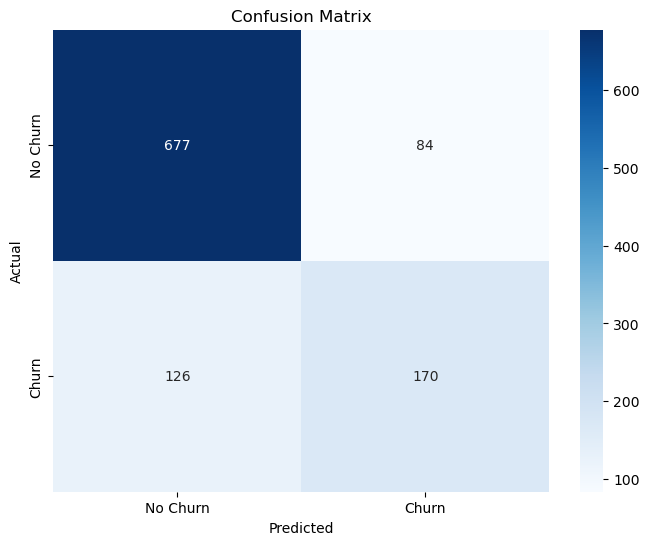

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87       761
       Churn       0.67      0.57      0.62       296

    accuracy                           0.80      1057
   macro avg       0.76      0.73      0.74      1057
weighted avg       0.79      0.80      0.80      1057



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=['No Churn', 'Churn']))

### Understanding ROC-AUC
The ROC (Receiver Operating Characteristic) curve plots the True Positive Rate against False Positive Rate at various thresholds. It's particularly useful for churn prediction because:
- It's insensitive to class imbalance (common in churn data where most customers don't churn)
- AUC score range interpretation:
  - 0.9-1.0: Excellent prediction
  - 0.8-0.9: Good prediction
  - 0.7-0.8: Fair prediction
  - < 0.7: Poor prediction
- Helps choose optimal threshold for classifying churners

Look for a curve that rises sharply and stays close to the top-left corner.

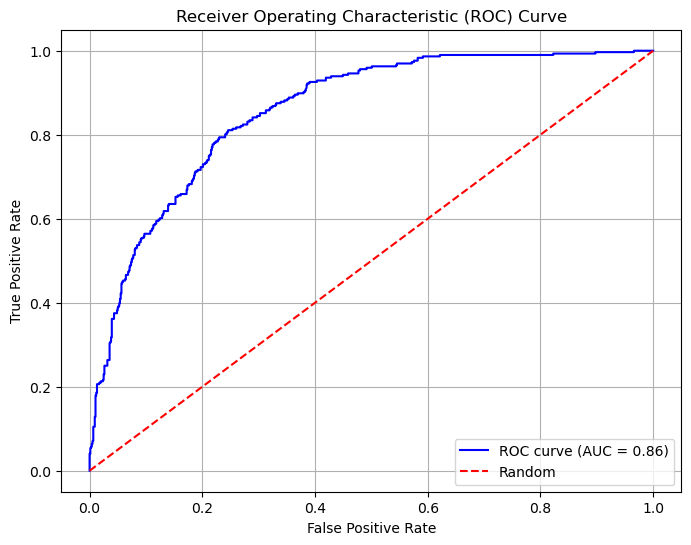

ROC-AUC Score: 0.857


In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import json

# Parse the predictions from bytes to JSON
decoded_predictions = json.loads(predictions.decode('utf-8'))
# Extract probability scores for the positive class (churn)
y_pred_proba = [pred['score'] for pred in decoded_predictions['predictions']]

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(test_labels, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc:.3f}")

### Understanding Precision-Recall Curve
The Precision-Recall curve is especially relevant for churn prediction because:
- Precision: Of all customers we predicted would churn, how many actually did?
- Recall: Of all actual churners, how many did we catch?

This helps balance between:
- Not wasting resources on retention efforts (precision)
- Not missing potential churners (recall)

For telecom churn, high recall might be more important as the cost of losing a customer (false negative) is typically higher than the cost of a retention action (false positive).

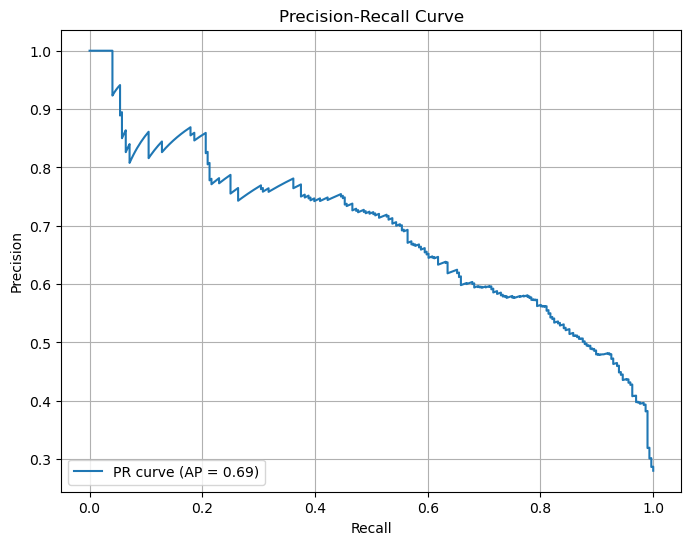

Average Precision Score: 0.689


In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Parse predictions (assuming same data structure as before)
decoded_predictions = json.loads(predictions.decode('utf-8'))
y_pred_proba = [pred['score'] for pred in decoded_predictions['predictions']]

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, y_pred_proba)
avg_precision = average_precision_score(test_labels, y_pred_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print(f"Average Precision Score: {avg_precision:.3f}")

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Given your business situation and goals, which metric(s) is most important for you to consider here? Why?

4. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

In [22]:
# Specify the endpoint name
endpoint_name = 'linear-learner-2024-12-03-06-11-49-901'

# Delete the endpoint
sm_client.delete_endpoint(EndpointName=endpoint_name)
print(f"Endpoint '{endpoint_name}' deleted successfully.")


Endpoint 'linear-learner-2024-12-03-06-11-49-901' deleted successfully.


# Step 4: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

Lets inspect the dataset once again and decide what can be done to improve the performance.

In [23]:
import pandas as pd

# Load the Telco Customer Churn dataset
file_path = 'Telco-Customer-Churn.csv'
telco_data = pd.read_csv(file_path)

# Inspect the dataset
print(telco_data.head())
print(telco_data.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

Class distribution:
No     5174
Yes    1869
Name: Churn, dtype: int64


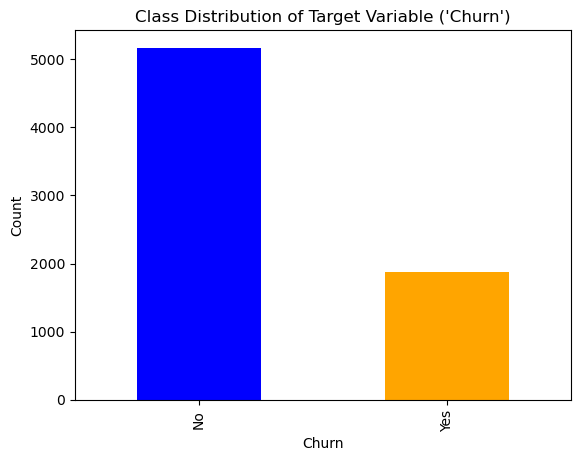

In [24]:
# Check class distribution
churn_counts = telco_data['Churn'].value_counts()
print("Class distribution:")
print(churn_counts)

# Plot class distribution
import matplotlib.pyplot as plt
churn_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution of Target Variable ('Churn')")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

There are two main ways to handle imbalanced datasets:

- Oversample to add more positive samples
    - Random oversampling
    - [Synthetic minority oversampling technique (SMOTE)](https://arxiv.org/abs/1106.1813)
- Undersample to reduce the negative samples
    - Random undersampling
    - Generate centroids using clustering methods
    
We can deduce that there are many negative examples in the dataset.
We will use SMOTE to increase the number of positive examples. We will seperate the features and target, do the split of the data and then check the class distribution. 

In [25]:
!pip install imblearn

In [26]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separate features and target
X = data.drop(columns=['Churn'])
y = data['Churn']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check class distribution in training data before SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

Class distribution before SMOTE:
0    3622
1    1308
Name: Churn, dtype: int64


In [27]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution after SMOTE:
0    3622
1    3622
Name: Churn, dtype: int64


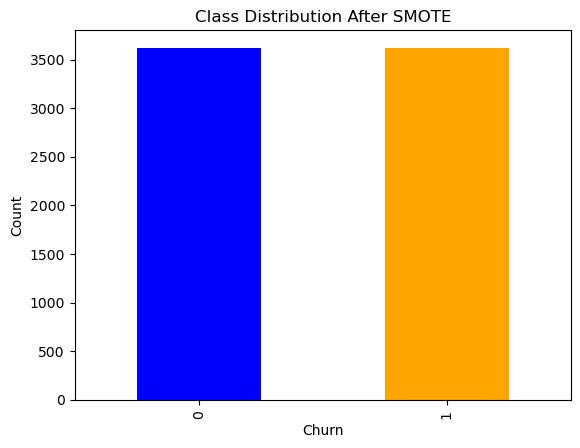

In [28]:
# Plot the class distribution after SMOTE
balanced_counts = pd.Series(y_train_smote).value_counts()
balanced_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution After SMOTE")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

In [29]:
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import os
import numpy as np

# Convert training data to NumPy arrays in float32 format
X_train_np = X_train_smote.to_numpy().astype('float32')  # Convert features
y_train_np = y_train_smote.to_numpy().astype('float32')  # Convert labels

# Save as a protobuf file
train_file = 'train_data'
with open(train_file, 'wb') as f:
    write_numpy_to_dense_tensor(f, X_train_np, y_train_np)

# Check file size for validation
print(f"Training data saved: {os.path.getsize(train_file)} bytes")


Training data saved: 1216992 bytes


In [30]:
train_data_s3_path = sagemaker_session.upload_data(
    path=train_file,
    bucket='sagemaker-us-west-2-935796931548',
    key_prefix='linear-learner-smote/train'
)
print("Training data S3 path:", train_data_s3_path)

Training data S3 path: s3://sagemaker-us-west-2-935796931548/linear-learner-smote/train/train_data


Define LinearLearner with instance count 1 and type as ml.m5.large

In [31]:

from sagemaker.estimator import Estimator
feature_dim = X_train_smote.shape[1]

# Retrieve the image URI for Linear Learner
container = sagemaker.image_uris.retrieve('linear-learner', sagemaker_session.boto_region_name)

# Define the Estimator with required hyperparameters
linear_learner = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'predictor_type': 'binary_classifier',
        'feature_dim': feature_dim,
        'epochs': 50,            # Fixed epochs
        'optimizer': 'adam',     # Fixed optimizer
        'mini_batch_size': 200,  # Fixed mini_batch_size
    }
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Define Sagemaker session and bucket for model artifacts

In [32]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket for model artifacts
bucket = 'sagemaker-us-west-2-935796931548'
prefix = 'linear-learner-churn-3'


In [34]:
import numpy as np
from sagemaker.inputs import TrainingInput
import io
import sagemaker.amazon.common as smac

# Combine features and labels into protobuf format
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train_np, y_train_np)
buf.seek(0)

# Upload the data to S3
import boto3
s3_client = boto3.client('s3')
train_data_key = f'{prefix}/train/train.recordio'
s3_client.put_object(Bucket=bucket, Key=train_data_key, Body=buf.getvalue())

# Create the S3 path for your training data
train_data_path = f's3://{bucket}/{train_data_key}'

# Create TrainingInput object
train_input = TrainingInput(
    s3_data=train_data_path,
    content_type='application/x-recordio-protobuf'
)

# Now fit the model using the new input format
linear_learner.fit({'train': train_input})

INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-03-06-22-57-770


2024-12-03 06:22:58 Starting - Starting the training job...
2024-12-03 06:23:21 Starting - Preparing the instances for training...
2024-12-03 06:23:55 Downloading - Downloading input data......
2024-12-03 06:24:41 Downloading - Downloading the training image......
2024-12-03 06:25:52 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/03/2024 06:25:56 INFO 140704156788544] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

In [35]:
# Deploy the trained model
predictor = linear_learner.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)


INFO:sagemaker:Creating model with name: linear-learner-2024-12-03-06-28-21-220
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-12-03-06-28-21-220
INFO:sagemaker:Creating endpoint with name linear-learner-2024-12-03-06-28-21-220


--------!

Serialize the features in CSV format and display the predictions. Use a threshold of 0.5 for the same. 

In [36]:
import io

# Serialize test features into CSV format
test_csv_buffer = io.StringIO()
np.savetxt(test_csv_buffer, test_features, delimiter=",", fmt='%s')  # Ensure `test_features` is a NumPy array
test_csv_data = test_csv_buffer.getvalue()

# Verify the serialized CSV data
print(type(test_csv_data))  # Ensure this is a string
print(test_csv_data[:500])  # Preview first 500 characters

from sagemaker.predictor import Predictor

# Create a predictor for the endpoint
predictor = Predictor(endpoint_name='linear-learner-2024-12-03-06-28-21-220', sagemaker_session=sagemaker.Session())

# Perform inference
predictions = predictor.predict(test_csv_data, initial_args={'ContentType': 'text/csv'})


# Example raw predictions (byte string from SageMaker endpoint)
raw_predictions = predictions
# Step 1: Decode and parse the byte string
decoded_predictions = raw_predictions.decode('utf-8')
parsed_predictions = json.loads(decoded_predictions)

# Step 2: Extract scores and predicted labels
predictions_list = parsed_predictions['predictions']
scores = [entry['score'] for entry in predictions_list]
predicted_labels = [entry['predicted_label'] for entry in predictions_list]

# Step 3: Convert scores to binary labels using a threshold
threshold = 0.5
y_pred = [1 if score >= threshold else 0 for score in scores]

# Print results
print("Scores:", scores[0])
print("Predicted Labels (from model):", predicted_labels[0])
print("Binary Labels (custom threshold):", y_pred[0])

<class 'str'>
1.0,0.0,1.0,0.0,1.0436162,1.0,1.0,-0.16158292,0.5400106,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,-1.1145631,1.0,0.0,0.34526518,-0.83407307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1.0,0.0,1.0,1.0,0.8807347,1.0,1.0,-1.3298262,-0.41488805,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
0.0,0.0,1.0,1.0,1.6137012,1.0,1.0,1.6381432,2.7311187,1.0,0.0,0.0,1.0,1.0,0.0
Scores: 0.872351884841919
Predicted Labels (from model): 0
Binary Labels (custom threshold): 1


Plot the confusion and classification matrix.

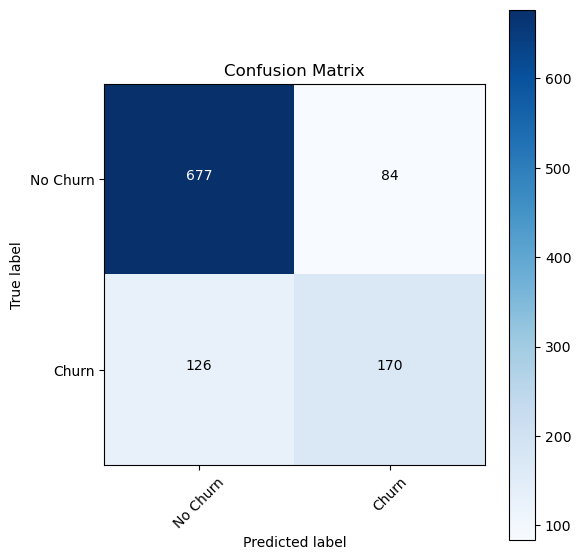

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.99      0.09      0.16       761
       Churn       0.30      1.00      0.46       296

    accuracy                           0.34      1057
   macro avg       0.64      0.54      0.31      1057
weighted avg       0.79      0.34      0.24      1057



In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Define class labels
class_labels = ['No Churn', 'Churn']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=['No Churn', 'Churn']))

 Plot ROC-AUC curve

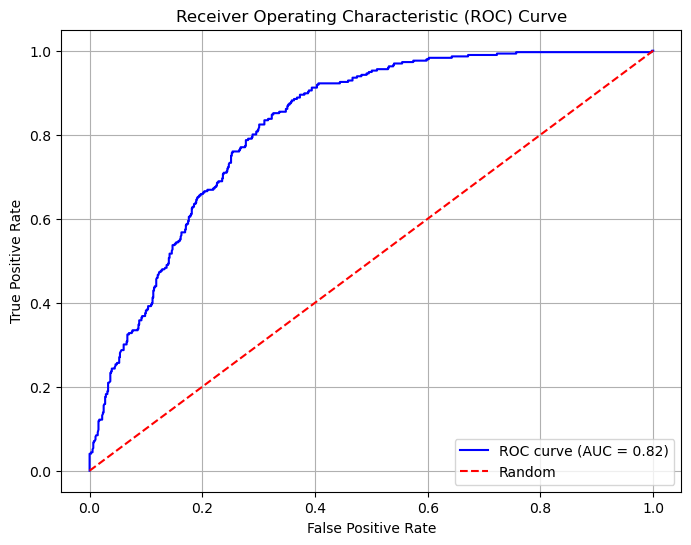

ROC-AUC Score: 0.824


In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import json

# Parse the predictions from bytes to JSON
decoded_predictions = json.loads(predictions.decode('utf-8'))
# Extract probability scores for the positive class (churn)
y_pred_proba = [pred['score'] for pred in decoded_predictions['predictions']]

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(test_labels, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc:.3f}")

 Plot precision-recall curve

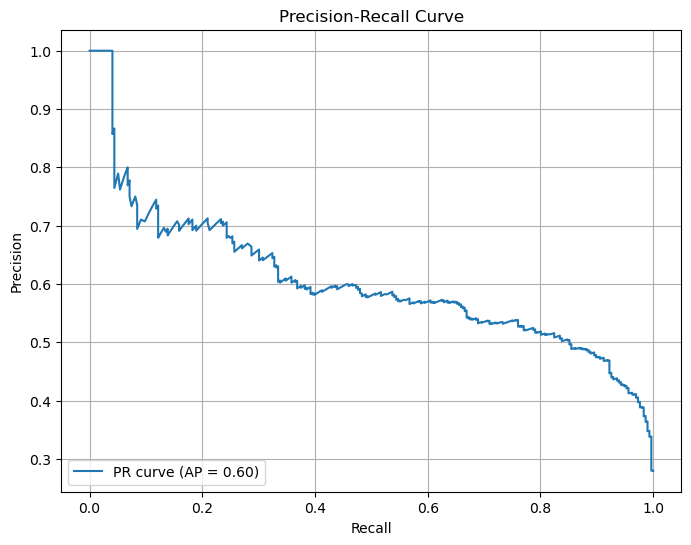

Average Precision Score: 0.604


In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Parse predictions (assuming same data structure as before)
decoded_predictions = json.loads(predictions.decode('utf-8'))
y_pred_proba = [pred['score'] for pred in decoded_predictions['predictions']]

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, y_pred_proba)
avg_precision = average_precision_score(test_labels, y_pred_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print(f"Average Precision Score: {avg_precision:.3f}")

What can you deduce from the output above? Has the performance improved for the model?
Does it meet your business goals?
Are you aware about any more techniques that can improve the model performance?
Optional Step: Apply hyperparameter tuning to above solution to check if it can improve the performance. 

# Step 5: Hyperparameter Tuning

When you build complex machine learning systems like deep learning neural networks, exploring all of the possible combinations is impractical. Hyperparameter tuning can accelerate your productivity by trying many variations of a model. It looks for the best model automatically by focusing on the most promising combinations of hyperparameter values within the ranges that you specify. To get good results, you must choose the right ranges to explore.

Refer to this [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) to explore hyperparameter tuning strategies available in Amazon SageMaker


In [40]:
# Import necessary modules
import os
import numpy as np
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter
from sagemaker.amazon.common import write_numpy_to_dense_tensor
from sklearn.model_selection import train_test_split

# Split the SMOTE data into training and validation sets
X_train_smote_train, X_train_smote_val, y_train_smote_train, y_train_smote_val = train_test_split(
    X_train_smote, y_train_smote, test_size=0.2, random_state=42
)

# Convert to NumPy arrays in float32 format
X_train_np = X_train_smote_train.to_numpy().astype('float32')
y_train_np = y_train_smote_train.to_numpy().astype('float32')

X_val_np = X_train_smote_val.to_numpy().astype('float32')
y_val_np = y_train_smote_val.to_numpy().astype('float32')

# Save training data to a local file in RecordIO protobuf format
train_file = 'train_data'
with open(train_file, 'wb') as f:
    write_numpy_to_dense_tensor(f, X_train_np, y_train_np)

# Save validation data to a local file in RecordIO protobuf format
validation_file = 'validation_data'
with open(validation_file, 'wb') as f:
    write_numpy_to_dense_tensor(f, X_val_np, y_val_np)

# Upload the data to S3
s3_train_path = sagemaker_session.upload_data(train_file, bucket=bucket, key_prefix=f'{prefix}/train')
s3_validation_path = sagemaker_session.upload_data(validation_file, bucket=bucket, key_prefix=f'{prefix}/validation')

# Specify the data channels
data_channels = {
    'train': s3_train_path,
    'validation': s3_validation_path
}

# Define hyperparameter ranges (only tunable hyperparameters)
hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.0001, 0.2),
    'l1': ContinuousParameter(0.0, 1.0),
    'wd': ContinuousParameter(0.0, 1.0),  # 'wd' is weight decay (L2 regularization)
    'use_bias': CategoricalParameter(['True', 'False']),  # Use strings for booleans
    'positive_example_weight_mult': ContinuousParameter(0.5, 1.0)
}

# Define the objective metric
objective_metric_name = 'validation:binary_classification_accuracy'

# Metric definitions for parsing the logs
metric_definitions = [
    {'Name': 'validation:binary_classification_accuracy', 'Regex': 'validation: BinaryClassificationAccuracy=([0-9\\.]+)'},
]

# Create a HyperparameterTuner
tuner = HyperparameterTuner(
    estimator=linear_learner,
    objective_metric_name=objective_metric_name,
    objective_type='Maximize',  # We aim to maximize accuracy
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=20,                # Total number of training jobs
    max_parallel_jobs=2         # How many training jobs can run in parallel
)

# Start hyperparameter tuning
tuner.fit(inputs=data_channels)

INFO:sagemaker:Creating hyperparameter tuning job with name: linear-learner-241203-0633


..................................................................................................................................................................................................!


In [41]:
# Deploy the best model
best_estimator = tuner.best_estimator()
predictor = best_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)


2024-12-03 06:47:42 Starting - Found matching resource for reuse
2024-12-03 06:47:42 Downloading - Downloading the training image
2024-12-03 06:47:42 Training - Training image download completed. Training in progress.
2024-12-03 06:47:42 Uploading - Uploading generated training model
2024-12-03 06:47:42 Completed - Resource reused by training job: linear-learner-241203-0633-018-725af685

INFO:sagemaker:Creating model with name: linear-learner-2024-12-03-06-50-26-888


INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-12-03-06-50-26-888
INFO:sagemaker:Creating endpoint with name linear-learner-2024-12-03-06-50-26-888


-------!

Now perform similar evaluation techniques as previous steps

In [42]:
import io

# Serialize test features into CSV format
test_csv_buffer = io.StringIO()
np.savetxt(test_csv_buffer, test_features, delimiter=",", fmt='%s')  # Ensure `test_features` is a NumPy array
test_csv_data = test_csv_buffer.getvalue()

# Verify the serialized CSV data
print(type(test_csv_data))  # Ensure this is a string
print(test_csv_data[:500])  # Preview first 500 characters

from sagemaker.predictor import Predictor

# Create a predictor for the endpoint
predictor = Predictor(endpoint_name='linear-learner-2024-12-03-06-50-26-888', sagemaker_session=sagemaker.Session())

# Perform inference
predictions = predictor.predict(test_csv_data, initial_args={'ContentType': 'text/csv'})


# Example raw predictions (byte string from SageMaker endpoint)
raw_predictions = predictions
# Step 1: Decode and parse the byte string
decoded_predictions = raw_predictions.decode('utf-8')
parsed_predictions = json.loads(decoded_predictions)

# Step 2: Extract scores and predicted labels
predictions_list = parsed_predictions['predictions']
scores = [entry['score'] for entry in predictions_list]
predicted_labels = [entry['predicted_label'] for entry in predictions_list]

# Step 3: Convert scores to binary labels using a threshold
threshold = 0.5
y_pred = [1 if score >= threshold else 0 for score in scores]

# Print results
print("Scores:", scores[0])
print("Predicted Labels (from model):", predicted_labels[0])
print("Binary Labels (custom threshold):", y_pred[0])

<class 'str'>
1.0,0.0,1.0,0.0,1.0436162,1.0,1.0,-0.16158292,0.5400106,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,-1.1145631,1.0,0.0,0.34526518,-0.83407307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1.0,0.0,1.0,1.0,0.8807347,1.0,1.0,-1.3298262,-0.41488805,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
0.0,0.0,1.0,1.0,1.6137012,1.0,1.0,1.6381432,2.7311187,1.0,0.0,0.0,1.0,1.0,0.0
Scores: 0.03665894269943237
Predicted Labels (from model): 0
Binary Labels (custom threshold): 0


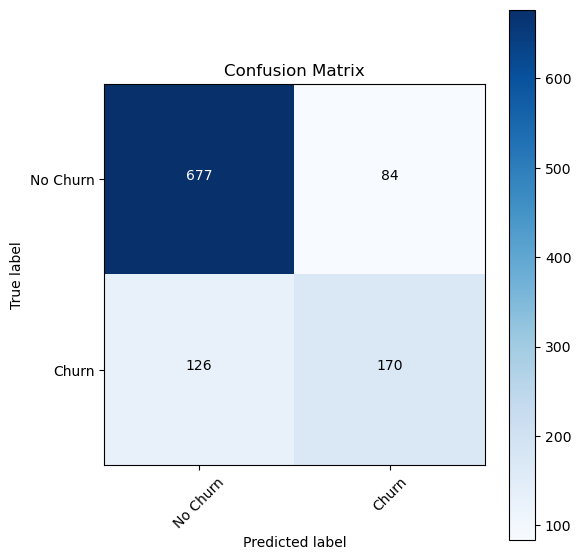

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.83       761
       Churn       0.57      0.79      0.66       296

    accuracy                           0.77      1057
   macro avg       0.73      0.78      0.74      1057
weighted avg       0.81      0.77      0.78      1057



In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Define class labels
class_labels = ['No Churn', 'Churn']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=['No Churn', 'Churn']))

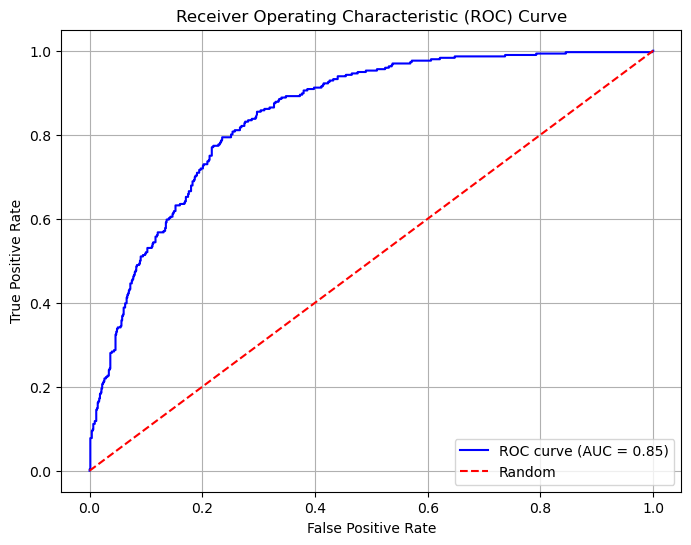

ROC-AUC Score: 0.848


In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import json

# Parse the predictions from bytes to JSON
decoded_predictions = json.loads(predictions.decode('utf-8'))
# Extract probability scores for the positive class (churn)
y_pred_proba = [pred['score'] for pred in decoded_predictions['predictions']]

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(test_labels, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc:.3f}")

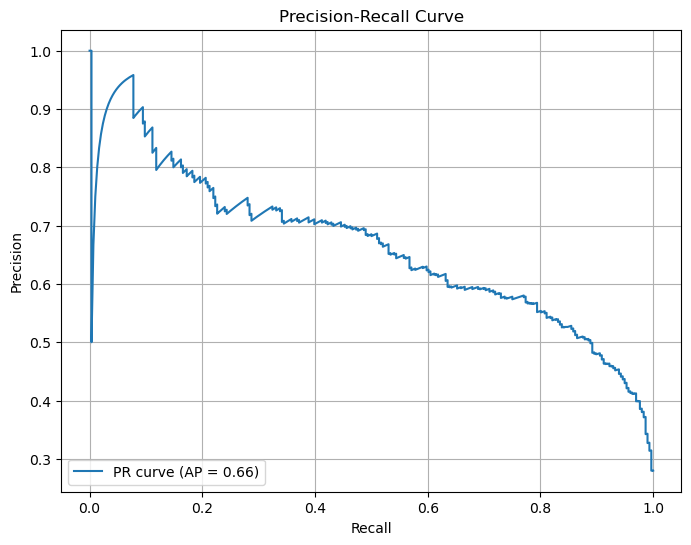

Average Precision Score: 0.664


In [45]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Parse predictions (assuming same data structure as before)
decoded_predictions = json.loads(predictions.decode('utf-8'))
y_pred_proba = [pred['score'] for pred in decoded_predictions['predictions']]

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, y_pred_proba)
avg_precision = average_precision_score(test_labels, y_pred_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print(f"Average Precision Score: {avg_precision:.3f}")

### Final Model Analysis & Conclusions

After hyperparameter tuning, it's crucial to analyze how our model performance changed:

1. Impact of Hyperparameter Tuning:
   - While we found the "best" model through tuning, our metrics show that the improvements were modest
   - This suggests that the basic model architecture might be a limiting factor, not just the parameters
   - Sometimes simpler models have an inherent performance ceiling that tuning alone can't overcome

2. Evaluation Metrics Review:
   - **Confusion Matrix**: Still shows imbalance in prediction capabilities
     - The model remains better at identifying non-churners than churners
     - This is a common challenge in churn prediction due to class imbalance
   
   - **ROC-AUC**: A good but not excellent score
     - Shows model performs better than random but has room for improvement
     - Suggests we might need to look beyond just tuning hyperparameters
   
   - **Precision-Recall**: Trade-off remains significant
     - Difficulty in simultaneously achieving high precision and recall
     - Indicates we might need different approaches for better balance

3. Next Steps to Consider:
   - Feature engineering might have more impact than further parameter tuning
   - Consider trying different model architectures (e.g., ensemble methods, deep learning)
   - Collect more data or different types of features
   - Address class imbalance through advanced sampling techniques
   - Consider business-specific cost functions instead of standard metrics

Remember: In real-world churn prediction, a modest improvement in model performance can translate to significant business value. The goal isn't always to achieve perfect metrics, but to create a model that provides actionable insights and positive ROI for retention efforts.